In [2]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

c:\Users\Henrique\anaconda3\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59443 instead
  warnings.warn(


In [4]:
scores_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\users_with_scores.parquet')
scores_ddf = scores_ddf.compute()
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0


In [5]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf = ratings_ddf.compute()
ratings_ddf.head()

,date,bid,uid,rating,has_review,review,compound
0,2015-08-20 10:00:00,142544,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0
1,2015-11-14 11:00:00,120824,nmann08.184925,3.56,False,None,0
2,2011-11-18 11:00:00,47581,nmann08.184925,4.50,False,None,0
3,2013-05-03 10:00:00,93113,nmann08.184925,3.75,False,None,0
4,2015-01-24 11:00:00,875,nmann08.184925,3.81,False,None,0


In [6]:
beers_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\beers.parquet')
beers_ddf = beers_ddf.compute()
beers_ddf.head()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


# Beer Style Analysis
1) what types of beers are rated more by each categories relative to their number of ratings
2) what type of beer each category like more (ie. are the ratings better for some category of beers)

## What style of beer are more rated by each category

In [7]:
# get user for each category
cfm_users = scores_ddf[scores_ddf["is_cfm"] == True]
exp_users = scores_ddf[scores_ddf["is_exp"] == True]
xpl_users = scores_ddf[scores_ddf["is_xpl"] == True]
adv_users = scores_ddf[scores_ddf["is_adv"] == True]

# group by rating for each category
cfm_ratings = ratings_ddf[ratings_ddf["uid"].isin(cfm_users["uid"])]
exp_ratings = ratings_ddf[ratings_ddf["uid"].isin(exp_users["uid"])]
xpl_ratings = ratings_ddf[ratings_ddf["uid"].isin(xpl_users["uid"])]
adv_ratings = ratings_ddf[ratings_ddf["uid"].isin(adv_users["uid"])]



In [170]:
cfm_ratings

,date,bid,uid,rating,has_review,review,compound,style
0,2014-01-25 11:00:00,19827,jaydoc.265507,3.25,False,None,0,English Pale Ale
1,2012-12-02 11:00:00,19827,byofb.537281,3.50,False,None,0,English Pale Ale
2,2012-07-14 10:00:00,19827,othershoe2.233642,3.68,True,Pours a rich brownish red with some chill haze...,0,English Pale Ale
3,2012-01-02 11:00:00,19827,animal69.160100,3.50,False,None,0,English Pale Ale
4,2011-09-07 10:00:00,19827,treyliff.490010,3.62,True,Pours a dark brown with a decent creamy head. ...,0,English Pale Ale
...,...,...,...,...,...,...,...,...
1271041,2009-03-12 11:00:00,48172,rwdkosak.299494,4.23,True,"On-tap at MBC in pint glass. Dark, dark beer, ...",0,American Porter
1271042,2009-03-12 11:00:00,47237,rwdkosak.299494,3.92,True,Had this on tap initially at the first samplin...,0,Witbier
1271043,2009-03-12 11:00:00,48112,rwdkosak.299494,4.03,True,Had this on tap as part of a flight of MBC bre...,0,Dubbel
1271044,2009-12-01 11:00:00,22574,traviserickson.391459,3.48,True,A- head falls apart like with a quick swiss ch...,0,American Pale Ale (APA)


In [9]:
# get style of beer for each bid
cfm_ratings = cfm_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
exp_ratings = exp_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
xpl_ratings = xpl_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
adv_ratings = adv_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
overall_ratings = ratings_ddf.merge(beers_ddf[["bid", "style"]], on="bid")

In [10]:
overall_ratings.shape

(7654894, 8)

In [11]:
# count of each style for each category
cfm_style_count = cfm_ratings.groupby("style").count()["uid"]
exp_style_count = exp_ratings.groupby("style").count()["uid"]
xpl_style_count = xpl_ratings.groupby("style").count()["uid"]
adv_style_count = adv_ratings.groupby("style").count()["uid"]
overall_style_count = overall_ratings.groupby("style").count()["uid"]


In [12]:
# normalize count of each style for each category by number of ratings for each category
cfm_style_count = cfm_style_count / cfm_ratings.shape[0]
exp_style_count = exp_style_count / exp_ratings.shape[0]
xpl_style_count = xpl_style_count / xpl_ratings.shape[0]
adv_style_count = adv_style_count / adv_ratings.shape[0]
overall_style_count = overall_style_count / overall_ratings.shape[0]

In [13]:
# sort by highest count
cfm_style_count = cfm_style_count.sort_values(ascending=False)
exp_style_count = exp_style_count.sort_values(ascending=False)
xpl_style_count = xpl_style_count.sort_values(ascending=False)
adv_style_count = adv_style_count.sort_values(ascending=False)
overall_style_count = overall_style_count.sort_values(ascending=False)

In [14]:
# get top 10 styles for each category
cfm_style_count_top_10 = cfm_style_count[:10]
exp_style_count_top_10 = exp_style_count[:10]
xpl_style_count_top_10 = xpl_style_count[:10]
adv_style_count_top_10 = adv_style_count[:10]
overall_style_count_top_10 = overall_style_count[:10]

In [15]:
# get list of all styles which are present in the top 10 of any category
styles = list(set(cfm_style_count_top_10.index).union(set(exp_style_count_top_10.index)).union(set(xpl_style_count_top_10.index)).union(set(adv_style_count_top_10.index)).union(set(overall_style_count_top_10.index)))
styles

['Saison / Farmhouse Ale',
 'American IPA',
 'American Porter',
 'American Amber / Red Ale',
 'Light Lager',
 'American Adjunct Lager',
 'Quadrupel (Quad)',
 'Witbier',
 'Russian Imperial Stout',
 'American Double / Imperial Stout',
 'American Pale Ale (APA)',
 'Fruit / Vegetable Beer',
 'American Wild Ale',
 'American Double / Imperial IPA',
 'Euro Pale Lager',
 'German Pilsener']

In [16]:
# keep only styles which are present in the top 10 of any category
cfm_style_count = cfm_style_count[cfm_style_count.index.isin(styles)]
exp_style_count = exp_style_count[exp_style_count.index.isin(styles)]
xpl_style_count = xpl_style_count[xpl_style_count.index.isin(styles)]
adv_style_count = adv_style_count[adv_style_count.index.isin(styles)]
overall_style_count = overall_style_count[overall_style_count.index.isin(styles)]

Goal: obtain the percentage of rating for each style of beer(percent in terms of their total number of rating) for each category of users

In [17]:
overall_style_count

style
American IPA                        0.120096
American Double / Imperial IPA      0.089675
American Double / Imperial Stout    0.060493
American Pale Ale (APA)             0.046723
Saison / Farmhouse Ale              0.036436
American Wild Ale                   0.032632
American Porter                     0.031244
Russian Imperial Stout              0.030692
American Amber / Red Ale            0.024390
Fruit / Vegetable Beer              0.020014
Witbier                             0.014655
American Adjunct Lager              0.012252
Quadrupel (Quad)                    0.010645
German Pilsener                     0.009590
Light Lager                         0.006586
Euro Pale Lager                     0.005671
Name: uid, dtype: float64

In [18]:
# convert style count for each category to percentage with rounding
cfm_style_count = cfm_style_count.apply(lambda x: round(x * 100, 2))
exp_style_count = exp_style_count.apply(lambda x: round(x * 100, 2))
xpl_style_count = xpl_style_count.apply(lambda x: round(x * 100, 2))
adv_style_count = adv_style_count.apply(lambda x: round(x * 100, 2))
overall_style_count = overall_style_count.apply(lambda x: round(x * 100, 2))

In [165]:
# create interactive vertical bar plot of top 10 styles for each category using style_count
# you can click on a category to display it and the plot are superimposed on each other

import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Bar(
    y=cfm_style_count.values / 100,
    x=cfm_style_count.index,
    name="Conformist",
    orientation='v',
    marker_color='#4477AA'
))
fig.add_trace(go.Bar(
    y=exp_style_count.values / 100,
    x=exp_style_count.index,
    name="Expert-like",
    orientation='v',
    marker_color='#CCBB44'
))
fig.add_trace(go.Bar(
    y=xpl_style_count.values / 100,
    x=xpl_style_count.index,
    name="Explorer",
    orientation='v',
    marker_color='#228833'
))
fig.add_trace(go.Bar(
    y=adv_style_count.values / 100,
    x=adv_style_count.index,
    name="Adventurer",
    orientation='v',
    marker_color='#AA3377'
))
fig.add_trace(go.Bar(
    y=overall_style_count.values / 100,
    x=overall_style_count.index,
    name="Overall",
    orientation='v',
    marker_color='#777777'
    
))
# set y axis to be percentage
fig.update_layout(yaxis_tickformat = '.0%')

# make plot transparent
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_style_count.index})

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Percentage of Ratings")

# set the title
fig.update_layout(title_text="Beer styles with most number of ratings per user category")

fig.update_layout(barmode='group')

# save the plot to html
fig.write_html("top_beer_styles.html")

# show the plot
fig.show()


### analysis:
When we select 'overall' and 'conformist', we see that these two categories are very similar in terms of rated beer styles.  
However, by selecting 'overall' and 'expert_like' or 'explorer' we see a similar ranking, but the distribution is not the same. This motivates the idea that 'conformist' are the closest user to the lambda user.  
Finally, we see a very different ranking and distribution for the adventurers. It seems like they rate very different kind of beers compared to the other users.


## What style of beer are more liked by each category

In [21]:
# group by cfm_ratings by style and get average rating for each style
cfm_ratings_by_style = cfm_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
exp_ratings_by_style = exp_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
xpl_ratings_by_style = xpl_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
adv_ratings_by_style = adv_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
overall_ratings_by_style = overall_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)

# normalize the avg ratings by dividing by the average rating for all their ratings
cfm_ratings_by_style['norm_rating'] = cfm_ratings_by_style['rating'] / cfm_ratings['rating'].mean()
exp_ratings_by_style['norm_rating'] = exp_ratings_by_style['rating'] / exp_ratings['rating'].mean()
xpl_ratings_by_style['norm_rating'] = xpl_ratings_by_style['rating'] / xpl_ratings['rating'].mean()
adv_ratings_by_style['norm_rating'] = adv_ratings_by_style['rating'] / adv_ratings['rating'].mean()
overall_ratings_by_style['norm_rating'] = overall_ratings_by_style['rating'] / overall_ratings['rating'].mean()

In [22]:
# get the top 10 styles for each category
cfm_ratings_by_style_top10 = cfm_ratings_by_style.head(10)
exp_ratings_by_style_top10 = exp_ratings_by_style.head(10)
xpl_ratings_by_style_top10 = xpl_ratings_by_style.head(10)
adv_ratings_by_style_top10 = adv_ratings_by_style.head(10)
overall_ratings_by_style_top10 = overall_ratings_by_style.head(10)

In [23]:
# get list of all styles which are present in the top 10 of any category
styles = list(set(cfm_ratings_by_style_top10.index).union(set(exp_ratings_by_style_top10.index)).union(set(xpl_ratings_by_style_top10.index)).union(set(adv_ratings_by_style_top10.index)).union(set(overall_ratings_by_style_top10.index)))
styles

['Flanders Red Ale',
 'Eisbock',
 'Quadrupel (Quad)',
 'Tripel',
 'Russian Imperial Stout',
 'American Double / Imperial Stout',
 'Belgian Strong Dark Ale',
 'Lambic - Fruit',
 'Belgian Strong Pale Ale',
 'English Barleywine',
 'Lambic - Unblended',
 'American Wild Ale',
 'American Double / Imperial IPA',
 'Weizenbock',
 'Gueuze']

In [24]:
# keep only styles which are present in the top 10 of any category
cfm_ratings_by_style_top = cfm_ratings_by_style[cfm_ratings_by_style.index.isin(styles)]
exp_ratings_by_style_top = exp_ratings_by_style[exp_ratings_by_style.index.isin(styles)]
xpl_ratings_by_style_top = xpl_ratings_by_style[xpl_ratings_by_style.index.isin(styles)]
adv_ratings_by_style_top = adv_ratings_by_style[adv_ratings_by_style.index.isin(styles)]
overall_ratings_by_style_top = overall_ratings_by_style[overall_ratings_by_style.index.isin(styles)]

In [161]:
# make the plot interactive
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cfm_ratings_by_style_top.index,
    y=cfm_ratings_by_style_top["norm_rating"].values,
    name='Conformist',
    orientation='v',
    marker_color='#4477AA'
))
fig.add_trace(go.Bar(
    x=exp_ratings_by_style_top.index,
    y=exp_ratings_by_style_top["norm_rating"].values,
    name='Expert-like',
    orientation='v',
    marker_color='#CCBB44'
))
fig.add_trace(go.Bar(
    x=xpl_ratings_by_style_top.index,
    y=xpl_ratings_by_style_top["norm_rating"].values,
    name='Explorer',
    orientation='v',
    marker_color='#228833'
))
fig.add_trace(go.Bar(
    x=adv_ratings_by_style_top.index,
    y=adv_ratings_by_style_top["norm_rating"].values,
    name='Adventurer',
    orientation='v',
    marker_color='#AA3377'
))

fig.add_trace(go.Bar(
    x=overall_ratings_by_style_top.index,
    y=overall_ratings_by_style_top["norm_rating"].values,
    name='Overall',
    orientation='v',
    marker_color='#777777'
))

# set y axis to start at 0.9 and end at 1.2
fig.update_yaxes(range=[0.9, 1.2])

# make plot transparent
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Average Rating (Normalized)")

# set the title
fig.update_layout(title_text="Comparing Average Ratings of Beers by Beer style")

# Change the bar mode
fig.update_layout(barmode='group')

# set lines using axhline
fig.add_hline(y=1, line_width=1.5, line_dash="dash", line_color="black")


# save the plot to html
fig.write_html("top_liked_beer_styles.html")

# show the plot
fig.show()


### Analysis:
Conformist, explorers and expert-like rate style of beers similarly compared to their average rating. It seems like they all agree that "Geuze", a belgian style of beer, is the best style overall.  
The only category that doesn't agree with this consensus is the adventurers. The Gueuzes are ranked 11 in their ranking. Their prefered style is quadrupel, which is also belgian and it's not the most common type of beer (at least for Americans).

In [169]:
# take 10 least liked beers for adventures
adv_ratings_by_style_bottom10 = adv_ratings_by_style.tail(10)

# sort in ascending order
adv_ratings_by_style_bottom10 = adv_ratings_by_style_bottom10.sort_values(by='rating', ascending=True)

# create interactive plot to show the 10 least liked beers for adventures
fig = go.Figure()

fig.add_trace(go.Bar(
    x=adv_ratings_by_style_bottom10.index,
    y=adv_ratings_by_style_bottom10["norm_rating"].values,
    name='Adventurer',
    marker_color='#AA3377'
))

# make plot transparent
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Average Rating (Normalized)")

# Change the bar mode
fig.update_layout(barmode='group', title="10 least liked beers for Adventurers")

# fix y axis to start at 0 and end at 1.2
fig.update_yaxes(range=[0, 1.2])

# set lines using axhline
fig.add_hline(y=1, line_width=1.5, line_dash="dash", line_color="black")


# save the plot to html
fig.write_html("adventurer_least_liked_beer_styles.html")

# show the plot
fig.show()


### Analysis:
By considering the top 10 worst style of beers according to adventurers, we see that the American Adjunct Lager is present, while being one of the most rated beers. We can also notice other beers that they rate a lot while considering it not good (eg. Euro Pale Lager). 
But we saw as well that adventurer also rate some popular beers a lot like the very popular American IPA. So they don't only rate beers styles that are considered as bad by them.

# To which country (country of the beer) the ratings of each category go ?

## Where are user of each category comming from ? (is there any difference) ?

In [27]:
# use cfm_users, exp_users, xpl_users, adv_users, and overall_users to get countries of users
xpl_users_by_country = xpl_users.groupby("country").count()
adv_users_by_country = adv_users.groupby("country").count()
exp_users_by_country = exp_users.groupby("country").count()
cfm_users_by_country = cfm_users.groupby("country").count()
overall_users_by_country = scores_ddf.groupby("country").count()

# get the top 4 countries for each category
xpl_users_by_country_top10 = xpl_users_by_country.sort_values(by="uid", ascending=False).head(4)
adv_users_by_country_top10 = adv_users_by_country.sort_values(by="uid", ascending=False).head(4)
exp_users_by_country_top10 = exp_users_by_country.sort_values(by="uid", ascending=False).head(4)
cfm_users_by_country_top10 = cfm_users_by_country.sort_values(by="uid", ascending=False).head(4)
overall_users_by_country_top10 = overall_users_by_country.sort_values(by="uid", ascending=False).head(4)




In [28]:
xpl_users_by_country_top10

,n_ratings,n_reviews,uid,username,joined,location,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
country,,,,,,,,,,,,,,
United States,6820,6820,6820,6820,6820,6820,6820,6820,6820,6820,6820,6820,6820,6820
Canada,608,608,608,608,608,608,608,608,608,608,608,608,608,608
England,192,192,192,192,192,192,192,192,192,192,192,192,192,192
Australia,150,150,150,150,150,150,150,150,150,150,150,150,150,150


In [29]:
# interactive pie chart with plotly for top 5 countries for each category
# you can choose a category to show and display the top 5 countries for that category
# you can also choose to show all categories at once

# make the plot interactive
fig = go.Figure()

# define the colors for each country blue, red, yellow, green, purple
colors = ['#0000FF', '#FF0000', '#FFFF00', '#00FF00', '#800080']

fig.add_trace(go.Pie(
    labels=xpl_users_by_country_top10.index,
    values=xpl_users_by_country_top10["uid"].values,
    name='Explorer',
    visible=False

))
fig.add_trace(go.Pie(
    labels=adv_users_by_country_top10.index,
    values=adv_users_by_country_top10["uid"].values,
    name='Adventurer',
    visible=False
))
fig.add_trace(go.Pie(
    labels=exp_users_by_country_top10.index,
    values=exp_users_by_country_top10["uid"].values,
    name='Expert-like',
    visible=False
))
fig.add_trace(go.Pie(
    labels=cfm_users_by_country_top10.index,
    values=cfm_users_by_country_top10["uid"].values,
    name='Conformist',
    visible=False
))
fig.add_trace(go.Pie(
    labels=overall_users_by_country_top10.index,
    values=overall_users_by_country_top10["uid"].values,
    name='Overall'
))


# create a dropdown menu to choose which category to show
# and set default to show Overall
fig.update_layout(
    updatemenus=[
        dict(
            x=-0.2,
            y=1.1,
            yanchor="top",
            xanchor="left",
            active=4,
            buttons=list([
                dict(label="Explorer",
                        method="update",
                        args=[{"visible": [True, False, False, False, False]},
                            {"title": "Top 4 Countries for Explorer"}]),
                dict(label="Adventurer",
                        method="update",
                        args=[{"visible": [False, True, False, False, False]},
                            {"title": "Top 4 Countries for Adventurer"}]),
                dict(label="Expert-like",
                        method="update",
                        args=[{"visible": [False, False, True, False, False]},
                            {"title": "Top 4 Countries for Expert-like"}]),
                dict(label="Conformist",
                        method="update",
                        args=[{"visible": [False, False, False, True, False]},
                            {"title": "Top 4 Countries for Conformist"}]),
                dict(label="Overall",
                        method="update",
                        args=[{"visible": [False, False, False, False, True]},
                            {"title": "Top 4 Countries Overall"}]),
            ]), 
        )
    ])
# make plot transparent
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# make the plot smaller
fig.update_layout(height=500, width=500)



fig.update_layout(title_text="Top 4 Countries Overall", title_x=0)

fig.show()

# save the plot to a html file
fig.write_html("top_countries_pie_chart.html")


Analysis: There are more canadian for explorer and adventurer because they are probably more likely to rate canadian beers (which are more rare)

##  To which country do the ratings for each category go to ?

In [129]:
BEERS_PATH = "Data/BeerAdvocate/beers.csv"
beers_df = pd.read_csv(BEERS_PATH)
beers_df.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [130]:
# load breweries data
BREWERIES_PATH = "Data/BeerAdvocate/breweries.csv"
breweries_df = pd.read_csv("Data/BeerAdvocate/breweries.csv")
breweries_df.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [131]:
# merge beers and breweries locations
beers_breweries_df = pd.merge(beers_df, breweries_df, left_on="brewery_id", right_on="id", how="left")
beers_breweries_df.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,id,location,name,nbr_beers
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5


In [132]:
# only keep beer_id and location
beers_breweries_df = beers_breweries_df[["beer_id", "location", "nbr_ratings"]]
beers_breweries_df.head()

,beer_id,location,nbr_ratings
0,166064,Kyrgyzstan,0
1,166065,Kyrgyzstan,0
2,166066,Kyrgyzstan,0
3,166067,Kyrgyzstan,0
4,166063,Kyrgyzstan,0


In [133]:
# group by location and count number of ratings
beers_breweries_df = beers_breweries_df.groupby("location").agg({"nbr_ratings": "sum"})
beers_breweries_df.head()

,nbr_ratings
location,
Albania,83
Algeria,17
Andorra,26
Angola,6
Antigua & Barbuda,51


In [134]:
# sort by number of ratings
beers_breweries_df = beers_breweries_df.sort_values(by="nbr_ratings", ascending=False)
beers_breweries_df.head(10)

,nbr_ratings
location,
"United States, California",1384998
"United States, Colorado",484803
"United States, Michigan",479548
"United States, New York",458950
"United States, Massachusetts",411348
Belgium,406845
"United States, Pennsylvania",349511
"United States, Oregon",307641
"United States, Illinois",281906


In [135]:
beers_breweries_df = pd.merge(beers_df, breweries_df, left_on="brewery_id", right_on="id", how="left")
beers_breweries_df.head()

# only keep beer_id and location
beers_breweries_df = beers_breweries_df[["beer_id", "location"]]


In [136]:
# merge with ratings
beers_breweries_ratings_df = pd.merge(beers_breweries_df, ratings_ddf, left_on="beer_id", right_on="bid", how="left")
beers_breweries_ratings_df.head()

,beer_id,location,date,bid,uid,rating,has_review,review,compound
0,166064,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,166065,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,166066,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,166067,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,166063,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# merge with scores_df
beers_breweries_ratings_scores_df = pd.merge(beers_breweries_ratings_df, scores_ddf, left_on="uid", right_on="uid", how="left")

In [138]:
# filter out nan ratings
beers_breweries_ratings_scores_df = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["rating"].notna()]
beers_breweries_ratings_scores_df.head()

,beer_id,location_x,date,bid,uid,rating,has_review,review,compound,n_ratings,...,location_y,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
23,142544,Gabon,2015-08-20 10:00:00,142544.0,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0.0,7820.0,...,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0.0,0.0,1.0,0.0
24,19590,Northern Ireland,2009-02-20 11:00:00,19590.0,stjamesgate.163714,3.67,True,Pours pale copper with a thin head that quickl...,0.0,2521.0,...,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0.0,0.0,1.0,0.0
25,19827,Northern Ireland,2014-12-01 11:00:00,19827.0,hellpop65.48993,3.25,False,None,0.0,2326.0,...,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0.0,0.0,0.0,0.0
26,19827,Northern Ireland,2014-05-29 10:00:00,19827.0,latarnik.52897,3.50,False,None,0.0,3098.0,...,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0.0,0.0,0.0,1.0
27,19827,Northern Ireland,2014-02-26 11:00:00,19827.0,rochefortchris.697017,3.50,False,None,0.0,1866.0,...,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0.0,0.0,1.0,0.0


In [139]:
# group by location and count number of ratings per location
location_count = beers_breweries_ratings_scores_df.groupby("location_x").agg({"rating": "count"})

# sort by number of ratings
location_count = location_count.sort_values(by="rating", ascending=False)
location_count.head(10)

,rating
location_x,
"United States, California",1281068
"United States, Colorado",450813
"United States, Michigan",446570
"United States, New York",429100
"United States, Massachusetts",385638
Belgium,338880
"United States, Pennsylvania",327811
"United States, Oregon",283117
"United States, Illinois",264166


In [140]:
# get list of locations with less than 100 ratings
locations_to_remove = location_count[location_count["rating"] < 100].index
locations_to_remove

Index(['Haiti', 'Canada, Alberta',
       'United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://theram.com" target="_blank">theram.com',
       'Uruguay', 'Montenegro', 'Egypt', 'Tanzania',
       'Canada, British Columbia', 'Albania', 'Nepal',
       ...
       'United Kingdom, Scotland', 'Paraguay',
       'Canada, Newfoundland and Labrador', 'Malawi', 'Libya', 'Botswana',
       'Guadeloupe', 'Gabon', 'Equatorial Guinea', 'Niger'],
      dtype='object', name='location_x', length=110)

In [141]:
# only keep beer_id, location, rating, and score
beers_breweries_ratings_scores_df = beers_breweries_ratings_scores_df[["beer_id", "uid", "location_x", "rating", "is_cfm", "is_exp", "is_xpl", "is_adv"]]

# rename location_x to beer_location
beers_breweries_ratings_scores_df = beers_breweries_ratings_scores_df.rename(columns={"location_x": "beer_location"})
beers_breweries_ratings_scores_df.head()

,beer_id,uid,beer_location,rating,is_cfm,is_exp,is_xpl,is_adv
23,142544,nmann08.184925,Gabon,2.88,0.0,0.0,1.0,0.0
24,19590,stjamesgate.163714,Northern Ireland,3.67,0.0,0.0,1.0,0.0
25,19827,hellpop65.48993,Northern Ireland,3.25,0.0,0.0,0.0,0.0
26,19827,latarnik.52897,Northern Ireland,3.50,0.0,0.0,0.0,1.0
27,19827,rochefortchris.697017,Northern Ireland,3.50,0.0,0.0,1.0,0.0


In [142]:
cfm_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_cfm"] == True]
exp_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_exp"] == True]
xpl_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_xpl"] == True]
adv_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_adv"] == True]
overall_ratings_by_location = beers_breweries_ratings_scores_df

# group by location and count number of ratings per location
cfm_ratings_by_location = cfm_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
exp_ratings_by_location = exp_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
xpl_ratings_by_location = xpl_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
adv_ratings_by_location = adv_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
overall_ratings_by_location = overall_ratings_by_location.groupby("beer_location").agg({"rating": "count"})

In [143]:
# locations with less than 10 ratings per category
cfm_locations_to_remove = cfm_ratings_by_location[cfm_ratings_by_location["rating"] < 10].index
exp_locations_to_remove = exp_ratings_by_location[exp_ratings_by_location["rating"] < 10].index
xpl_locations_to_remove = xpl_ratings_by_location[xpl_ratings_by_location["rating"] < 10].index
adv_locations_to_remove = adv_ratings_by_location[adv_ratings_by_location["rating"] < 10].index
overall_locations_to_remove = overall_ratings_by_location[overall_ratings_by_location["rating"] < 10].index

# locations with less than 10 ratings in any category
locations_low_rating = set(cfm_locations_to_remove).union(set(exp_locations_to_remove)).union(set(xpl_locations_to_remove)).union(set(adv_locations_to_remove)).union(set(overall_locations_to_remove))

In [144]:
# normalize by total number of ratings for each category
cfm_ratings_by_location["norm_rating"] = cfm_ratings_by_location["rating"] / cfm_ratings_by_location["rating"].sum()
exp_ratings_by_location["norm_rating"] = exp_ratings_by_location["rating"] / exp_ratings_by_location["rating"].sum()
xpl_ratings_by_location["norm_rating"] = xpl_ratings_by_location["rating"] / xpl_ratings_by_location["rating"].sum()
adv_ratings_by_location["norm_rating"] = adv_ratings_by_location["rating"] / adv_ratings_by_location["rating"].sum()
overall_ratings_by_location["norm_rating"] = overall_ratings_by_location["rating"] / overall_ratings_by_location["rating"].sum()

# sort by number of ratings
cfm_ratings_by_location = cfm_ratings_by_location.sort_values(by="rating", ascending=False)
exp_ratings_by_location = exp_ratings_by_location.sort_values(by="rating", ascending=False)
xpl_ratings_by_location = xpl_ratings_by_location.sort_values(by="rating", ascending=False)
adv_ratings_by_location = adv_ratings_by_location.sort_values(by="rating", ascending=False)
overall_ratings_by_location = overall_ratings_by_location.sort_values(by="rating", ascending=False)

# get top 10 locations
cfm_ratings_by_location_top_10 = cfm_ratings_by_location.head(10)
exp_ratings_by_location_top_10  = exp_ratings_by_location.head(10)
xpl_ratings_by_location_top_10  = xpl_ratings_by_location.head(10)
adv_ratings_by_location_top_10  = adv_ratings_by_location.head(10)
overall_ratings_by_location_top_10  = overall_ratings_by_location.head(10)

In [145]:
# get list of locations that are in any top 10
top_10_locations = set(cfm_ratings_by_location_top_10.index).union(set(exp_ratings_by_location_top_10.index)).union(set(xpl_ratings_by_location_top_10.index)).union(set(adv_ratings_by_location_top_10.index)).union(set(overall_ratings_by_location_top_10.index))
top_10_locations

{'Belgium',
 'Canada',
 'England',
 'Germany',
 'United States, California',
 'United States, Colorado',
 'United States, Illinois',
 'United States, Massachusetts',
 'United States, Michigan',
 'United States, Missouri',
 'United States, New York',
 'United States, Oregon',
 'United States, Pennsylvania',
 'United States, Vermont',
 'United States, Wisconsin'}

In [146]:
# filter out location that are not in no top 10 for each category
cfm_ratings_by_location = cfm_ratings_by_location[cfm_ratings_by_location.index.isin(top_10_locations)]
exp_ratings_by_location = exp_ratings_by_location[exp_ratings_by_location.index.isin(top_10_locations)]
xpl_ratings_by_location = xpl_ratings_by_location[xpl_ratings_by_location.index.isin(top_10_locations)]
adv_ratings_by_location = adv_ratings_by_location[adv_ratings_by_location.index.isin(top_10_locations)]
overall_ratings_by_location = overall_ratings_by_location[overall_ratings_by_location.index.isin(top_10_locations)]

In [158]:
# display x axis in percentage
fig = go.Figure()
fig.add_trace(go.Bar(
    y=cfm_ratings_by_location["norm_rating"],
    x=cfm_ratings_by_location.index,
    name="CFM",
    orientation='v',
    marker_color='#4477AA'
))
fig.add_trace(go.Bar(
    y=exp_ratings_by_location["norm_rating"] ,
    x=exp_ratings_by_location.index,
    name="EXP",
    orientation='v',
    marker_color='#CCBB44'
))
fig.add_trace(go.Bar(
    y=xpl_ratings_by_location["norm_rating"] ,
    x=xpl_ratings_by_location.index,
    name="XPL",
    orientation='v',
    marker_color='#228833'
))
fig.add_trace(go.Bar(
    y=adv_ratings_by_location["norm_rating"] ,
    x=adv_ratings_by_location.index,
    name="ADV",
    orientation='v',
    marker_color='#AA3377'
))
fig.add_trace(go.Bar(
    y=overall_ratings_by_location["norm_rating"] ,
    x=overall_ratings_by_location.index,
    name="Overall",
    orientation='v',
    marker_color='#777777'
))


fig.update_layout(barmode='group')


# add percentage to y axis
fig.update_yaxes(tickformat=".0%")

# set title
fig.update_layout(title_text="Comparing the Percentage of Ratings for Beers by Provenance")

# set y axis label
fig.update_yaxes(title_text='Percentage of Ratings')

# make plot transparent
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')

# save plot to html file
fig.write_html("beer_ratings_by_location.html")

# show plot
fig.show()


Analysis: We see a similar pattern for all categories, they rate beers from where they come from. Indeed, we see that most ratings go to the most populous states of the US. However, by selecting 'adventurer' and 'overall' only, we see that adventurers, while still rating beers from California a lot, have a different behaviour to the general rater. Indeed, by selecting only 'adventurer' we see that they also rate beers from other countries a lot: beers from Canada, Germany, Belgium and England for example.  
 While Canada may not be surprising since a lot of adventurer come from Canada, and also Belgium is not that suprising because we see that a lot of rated beers come from Belgium if we take the ratings overall. The other countries are more suprising since there is no user from Germany and England from the users we considered. Also, we can see that this countries have a low number of ratings for all other categories.  


It seems like adventurers are more likely to rate beers from other countries than the other categories.

# What country do each category like most ?

In [102]:
# get average rating for each location for each category and overall
cfm_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_cfm"] == True]
exp_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_exp"] == True]
xpl_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_xpl"] == True]
adv_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_adv"] == True]
overall_ratings_by_location = beers_breweries_ratings_scores_df


cfm_ratings_by_location = cfm_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
exp_ratings_by_location = exp_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
xpl_ratings_by_location = xpl_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
adv_ratings_by_location = adv_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
overall_ratings_by_location = overall_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})


In [103]:
cfm_ratings_by_location

,rating
beer_location,
Albania,3.315556
Andorra,2.250000
Angola,2.800000
Antigua & Barbuda,2.847500
Argentina,2.926750
...,...
Vietnam,2.782828
Virgin Islands (British),3.000000
Virgin Islands (U.S.),3.220833


In [104]:
# filter out locations with less than 10 ratings using locations_low_rating
cfm_ratings_by_location = cfm_ratings_by_location[~cfm_ratings_by_location.index.isin(cfm_locations_to_remove)]
exp_ratings_by_location = exp_ratings_by_location[~exp_ratings_by_location.index.isin(exp_locations_to_remove)]
xpl_ratings_by_location = xpl_ratings_by_location[~xpl_ratings_by_location.index.isin(xpl_locations_to_remove)]
adv_ratings_by_location = adv_ratings_by_location[~adv_ratings_by_location.index.isin(adv_locations_to_remove)]
overall_ratings_by_location = overall_ratings_by_location[~overall_ratings_by_location.index.isin(overall_locations_to_remove)]

# filter out locations to remove
cfm_ratings_by_location = cfm_ratings_by_location[~cfm_ratings_by_location.index.isin(locations_to_remove)]
exp_ratings_by_location = exp_ratings_by_location[~exp_ratings_by_location.index.isin(locations_to_remove)]
xpl_ratings_by_location = xpl_ratings_by_location[~xpl_ratings_by_location.index.isin(locations_to_remove)]
adv_ratings_by_location = adv_ratings_by_location[~adv_ratings_by_location.index.isin(locations_to_remove)]
overall_ratings_by_location = overall_ratings_by_location[~overall_ratings_by_location.index.isin(locations_to_remove)]

# filter out locations_to_remove_rating
cfm_ratings_by_location = cfm_ratings_by_location[~cfm_ratings_by_location.index.isin(locations_low_rating)]
exp_ratings_by_location = exp_ratings_by_location[~exp_ratings_by_location.index.isin(locations_low_rating)]
xpl_ratings_by_location = xpl_ratings_by_location[~xpl_ratings_by_location.index.isin(locations_low_rating)]
adv_ratings_by_location = adv_ratings_by_location[~adv_ratings_by_location.index.isin(locations_low_rating)]
overall_ratings_by_location = overall_ratings_by_location[~overall_ratings_by_location.index.isin(locations_low_rating)]

In [105]:
exp_ratings_by_location

,rating
beer_location,
Australia,3.766667
Austria,3.936250
Belgium,4.614735
Canada,3.896453
China,4.350714
...,...
"United States, Vermont",4.745837
"United States, Virginia",4.163511
"United States, Washington",4.207939


In [106]:
# normalize by average rating overall
cfm_ratings_by_location = cfm_ratings_by_location['rating'] / cfm_ratings["rating"].mean()
exp_ratings_by_location = exp_ratings_by_location['rating'] / exp_ratings["rating"].mean()
xpl_ratings_by_location = xpl_ratings_by_location['rating'] / xpl_ratings["rating"].mean()
adv_ratings_by_location = adv_ratings_by_location['rating'] / adv_ratings["rating"].mean()
overall_ratings_by_location = overall_ratings_by_location['rating'] / overall_ratings["rating"].mean()

In [107]:
# sort the the ratings series by rating
cfm_ratings_by_location = cfm_ratings_by_location.sort_values(ascending=False)
exp_ratings_by_location = exp_ratings_by_location.sort_values(ascending=False)
xpl_ratings_by_location = xpl_ratings_by_location.sort_values(ascending=False)
adv_ratings_by_location = adv_ratings_by_location.sort_values(ascending=False)
overall_ratings_by_location = overall_ratings_by_location.sort_values(ascending=False)



# get top 10 locations for each category and overall
cfm_ratings_by_location_top_10 = cfm_ratings_by_location[:10]
exp_ratings_by_location_top_10 = exp_ratings_by_location[:10]
xpl_ratings_by_location_top_10 = xpl_ratings_by_location[:10]
adv_ratings_by_location_top_10 = adv_ratings_by_location[:10]
overall_ratings_by_location_top_10 = overall_ratings_by_location[:10]

In [108]:
# get list of locations that appear in a top 10 list of any category
top_10_locations = list(set(cfm_ratings_by_location_top_10.index).union(set(exp_ratings_by_location_top_10.index)).union(set(xpl_ratings_by_location_top_10.index)).union(set(adv_ratings_by_location_top_10.index)).union(set(overall_ratings_by_location_top_10.index)))
top_10_locations

['United States, Iowa',
 'United States, Oregon',
 'United States, Indiana',
 'United States, Michigan',
 'Sweden',
 'Scotland',
 'United States, Ohio',
 'United States, Alaska',
 'United States, Arkansas',
 'United States, Vermont',
 'United States, California',
 'United States, Illinois',
 'Belgium',
 'United States, Delaware',
 'United States, Oklahoma',
 'United States, Florida',
 'United States, Maine',
 'United States, Massachusetts',
 'United States, Georgia']

In [109]:
# filter out locations that are not in the top 10 list of any category
cfm_ratings_by_location = cfm_ratings_by_location[cfm_ratings_by_location.index.isin(top_10_locations)]
exp_ratings_by_location = exp_ratings_by_location[exp_ratings_by_location.index.isin(top_10_locations)]
xpl_ratings_by_location = xpl_ratings_by_location[xpl_ratings_by_location.index.isin(top_10_locations)]
adv_ratings_by_location = adv_ratings_by_location[adv_ratings_by_location.index.isin(top_10_locations)]
overall_ratings_by_location = overall_ratings_by_location[overall_ratings_by_location.index.isin(top_10_locations)]




In [110]:
overall_ratings_by_location

beer_location
United States, Iowa             1.071670
United States, Oklahoma         1.058052
Belgium                         1.049095
United States, Indiana          1.048696
United States, Vermont          1.046038
United States, California       1.034708
United States, Florida          1.031178
United States, Illinois         1.030957
United States, Ohio             1.030743
United States, Michigan         1.029152
United States, Alaska           1.017444
United States, Oregon           1.016366
United States, Maine            1.016046
United States, Delaware         1.013408
Sweden                          1.009762
United States, Massachusetts    0.994846
United States, Georgia          0.992992
Scotland                        0.986607
United States, Arkansas         0.980241
Name: rating, dtype: float64

In [127]:
fig = go.Figure()


fig.add_trace(go.Bar(
    y=cfm_ratings_by_location.values,
    x=cfm_ratings_by_location.index,
    name="Conformist",
    orientation='v',
    marker_color='#4477AA'
))
fig.add_trace(go.Bar(
    y=exp_ratings_by_location.values,
    x=exp_ratings_by_location.index,
    name="Expert-like",
    orientation='v',
    marker_color='#CCBB44'
))
fig.add_trace(go.Bar( 
    y=xpl_ratings_by_location.values,
    x=xpl_ratings_by_location.index,
    name="Explorer",
    orientation='v',
    marker_color='#228833'
))
fig.add_trace(go.Bar(
    y=adv_ratings_by_location.values,
    x=adv_ratings_by_location.index,
    name="Adventurer",
    orientation='v',
    marker_color='#AA3377'
))
fig.add_trace(go.Bar(
    y=overall_ratings_by_location.values,
    x=overall_ratings_by_location.index,
    name="Overall",
    orientation='v',
    marker_color='#777777'
))


fig.update_yaxes(range=[0.8, 1.2])

# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_ratings_by_location.index})

# set title
fig.update_layout(title_text="Comparing Average Ratings of Beers by Provenance")

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Average Rating (Normalized)")

fig.update_layout(barmode='group')

# set lines using axhline
fig.add_hline(y=1, line_width=1.5, line_dash="dash", line_color="black")


# make the plot transparent
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# save to html
fig.write_html("beer_location_most_liked.html")

# show the plot
fig.show()




Analysis: Conformist, EXP and explorers mostly agree on the best beer provenance. Moreover, they all have a similar liking compared to users in general.  
However, adventurers have different preferences. By selecting "adventurer" and "overall" on the plot, we see for example that they like more beers from Belgium compared to the general users. There is also is a huge difference for beers from Scotland. Overall, they have very different opinions compared to the other categories.

# Venn diagram of categories 

In [60]:
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0


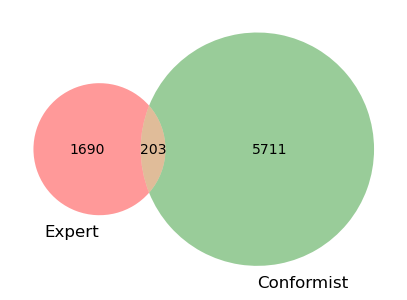

In [61]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Select the columns to visualize
experts = scores_ddf[scores_ddf['is_exp'] == 1]
conformists = scores_ddf[scores_ddf['is_cfm'] == 1]

# Calculate the number of users in each category
expert_count = len(experts)
conformist_count = len(conformists)
overlap_count = len(experts[experts['is_cfm'] == 1])

# Create the Venn diagram using the venn2 function
plt.figure(figsize=(5,5))
v = venn2(subsets=(expert_count, conformist_count, overlap_count), set_labels=('Expert', 'Conformist'))

# Show the plot
plt.show()



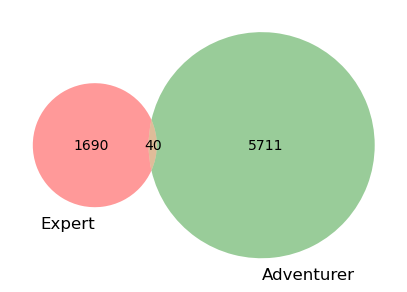

In [62]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Select the columns to visualize
experts = scores_ddf[scores_ddf['is_exp'] == 1]
adventurers = scores_ddf[scores_ddf['is_adv'] == 1]

# Calculate the number of users in each category
expert_count = len(experts)
adventurer_count = len(adventurers)
overlap_count = len(experts[experts['is_adv'] == 1])

# Create the Venn diagram using the venn2 function
plt.figure(figsize=(5,5))
v = venn2(subsets=(expert_count, conformist_count, overlap_count), set_labels=('Expert', 'Adventurer'))

# Show the plot
plt.show()


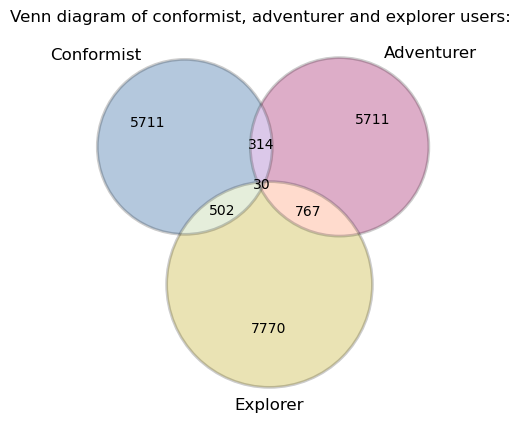

In [63]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn3_circles

# Ven diagram to show overlap of expert_like, conformist, adventurer and explorer

# Select the columns to visualize
conformist = scores_ddf[scores_ddf['is_cfm'] == 1]
adventurer = scores_ddf[scores_ddf['is_adv'] == 1]
explorer = scores_ddf[scores_ddf['is_xpl'] == 1]

# Calculate the number of users in each category
conformist_count = len(conformist)
adventurer_count = len(adventurer)
explorer_count = len(explorer)

# Calculate the overlap between the categories
conformist_adventurer_overlap = len(conformist[conformist['is_adv'] == 1])
conformist_explorer_overlap = len(conformist[conformist['is_xpl'] == 1])
adventurer_explorer_overlap = len(adventurer[adventurer['is_xpl'] == 1])
conformist_adventurer_explorer_overlap = len(conformist[(conformist['is_adv'] == 1) & (conformist['is_xpl'] == 1)])

# Create the Venn diagram using the venn3 function
plt.figure(figsize=(5,5))
plt.title("Venn diagram of conformist, adventurer and explorer users: ")
v = venn3(subsets=(conformist_count, adventurer_count, conformist_adventurer_overlap, 
                explorer_count, conformist_explorer_overlap, adventurer_explorer_overlap, conformist_adventurer_explorer_overlap),
           set_labels=('Conformist', 'Adventurer', 'Explorer'),
           set_colors=('#4477AA', '#AA3377', '#CCBB44'))



c = venn3_circles(subsets=(conformist_count, adventurer_count, conformist_adventurer_overlap, 
                explorer_count, conformist_explorer_overlap, adventurer_explorer_overlap, conformist_adventurer_explorer_overlap))

# set opacity of the circles
c[0].set_alpha(0.2)
c[1].set_alpha(0.2)
c[2].set_alpha(0.2)

# Show the plot
#plt.show()

# save to svg
plt.savefig('venn_diagram_categories.svg', format='svg', dpi=1200, transparent=True)

Analysis: there is very few overlap between explorers, conformists and adventurers. While the number of users with two of these categories is not negligible, the number of users with all three categories is very low.

In [64]:
conformist_count, adventurer_count, explorer_count,conformist_adventurer_overlap, conformist_explorer_overlap, adventurer_explorer_overlap, conformist_adventurer_explorer_overlap

(5711, 5711, 7770, 314, 502, 767, 30)